# Minimierung der Tardiness jedes Produktionsauftrags

In [1]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
from src.utils.new_filter import *
import src.utils.presenter as show
from src.utils.analize import check_constrains as check

# Solver Model
from src.models.lp import tardiness_scheduling as lp_tard_schedule
from src.models.lp import tardiness_rescheduling as lp_tard_reschedule

# Simulation
from src.simulation.ProductionRollingSimulation import ProductionSimulation

# Extern
import pandas as pd

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [2]:
# Harte Abbruchbedingung für die Scheduler
max_time = 60*15     # 15 min

# Simulation
simulation = ProductionSimulation(sigma = 0.15)

## I. Laden des fertigen Job-Shop Scheduling Problems und der dazugehörigen Produktionsauftragsinformationen

In [3]:
basic_data_path = get_path("data", "basic")
df_jssp = pd.read_csv(basic_data_path / "jssp_final.csv")
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
72494,J25-7249,4,4,M03,26
72495,J25-7249,4,5,M04,69
72496,J25-7249,4,6,M08,21


In [4]:
df_jobs_times = pd.read_csv(basic_data_path / "jobs_times_final.csv")
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
1,J25-0001,6,129,1440,2336.0,416,2338
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
...,...,...,...,...,...,...,...
7244,J25-7244,3,518085,518400,520251.0,655,520389
7245,J25-7245,9,518089,518400,520296.0,540,519640
7246,J25-7246,6,518116,518400,520027.0,416,520157


## Tag 1
- Am Tag 0 kommen die ersten Produktionsaufträge an, somit kann noch nichts geplant werden
- Am Tag 1 findet die initiale Planung statt

In [5]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [6]:
# "neue" und unerledigte Jobs
df_jobs_times_current = get_current_jobs(
    df_jobs_times, df_previous_not_started = None, ready_time=day_start
)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
1,J25-0001,6,129,1440,2336.0,416,2338
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
6,J25-0006,9,790,1440,2905.0,540,3539
7,J25-0007,5,925,1440,2930.0,496,2929
8,J25-0008,4,988,1440,2986.0,393,3541
9,J25-0009,7,1004,1440,3045.0,539,3578


In [7]:
df_jssp_current = filter_current_jssp(df_jssp, df_jobs_times_current)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
154,J25-0015,5,4,M08,48
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47


### Scheduling

#### a) Summe der Tardiness minimieren

$$
\min \; \sum_{j \in J} \max(0,\; C_j - d_j)
$$


- $J$: Menge aller Jobs
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$
- $d_j$: Deadline von Job $j$
- $\max(0,\; C_j - d_j)$: Tardiness von Job $j$
- Die Summe betrachtet **nur verspätete Jobs** – Frühfertigungen zählen nicht.

**Erklärung:**
Diese Zielfunktion minimiert die **Gesamtheit aller Verspätungen**, d. h. die Summe aller positiven Abweichungen von den Deadlines.

In [8]:
# Scheduling
df_schedule = lp_tard_schedule.solve_jssp_sum(
    df_jssp_current, df_jobs_times_current, solver= "HiGHS",
    earliest_start_column = "Ready Time", msg=False, timeLimit=max_time, gapRel= 0.01
)
df_schedule


Solver-Informationen:
  Summe Tardiness         : 0.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 1392
  Anzahl Constraints      : 2576
  Laufzeit                : ~1 Sekunden


,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Deadline,Start,End,Tardiness
0,J25-0000,8,0,M00,76,79,1440,3660,2887.0,2963.0,0.0
1,J25-0000,8,1,M01,69,79,1440,3660,2963.0,3032.0,0.0
2,J25-0000,8,2,M03,76,79,1440,3660,3032.0,3108.0,0.0
3,J25-0000,8,3,M05,51,79,1440,3660,3138.0,3189.0,0.0
4,J25-0000,8,4,M02,85,79,1440,3660,3189.0,3274.0,0.0
5,J25-0000,8,5,M09,11,79,1440,3660,3325.0,3336.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
154,J25-0015,5,4,M08,48,1436,1440,2981,2020.0,2068.0,0.0
155,J25-0015,5,5,M09,72,1436,1440,2981,2068.0,2140.0,0.0
156,J25-0015,5,6,M00,47,1436,1440,2981,2140.0,2187.0,0.0


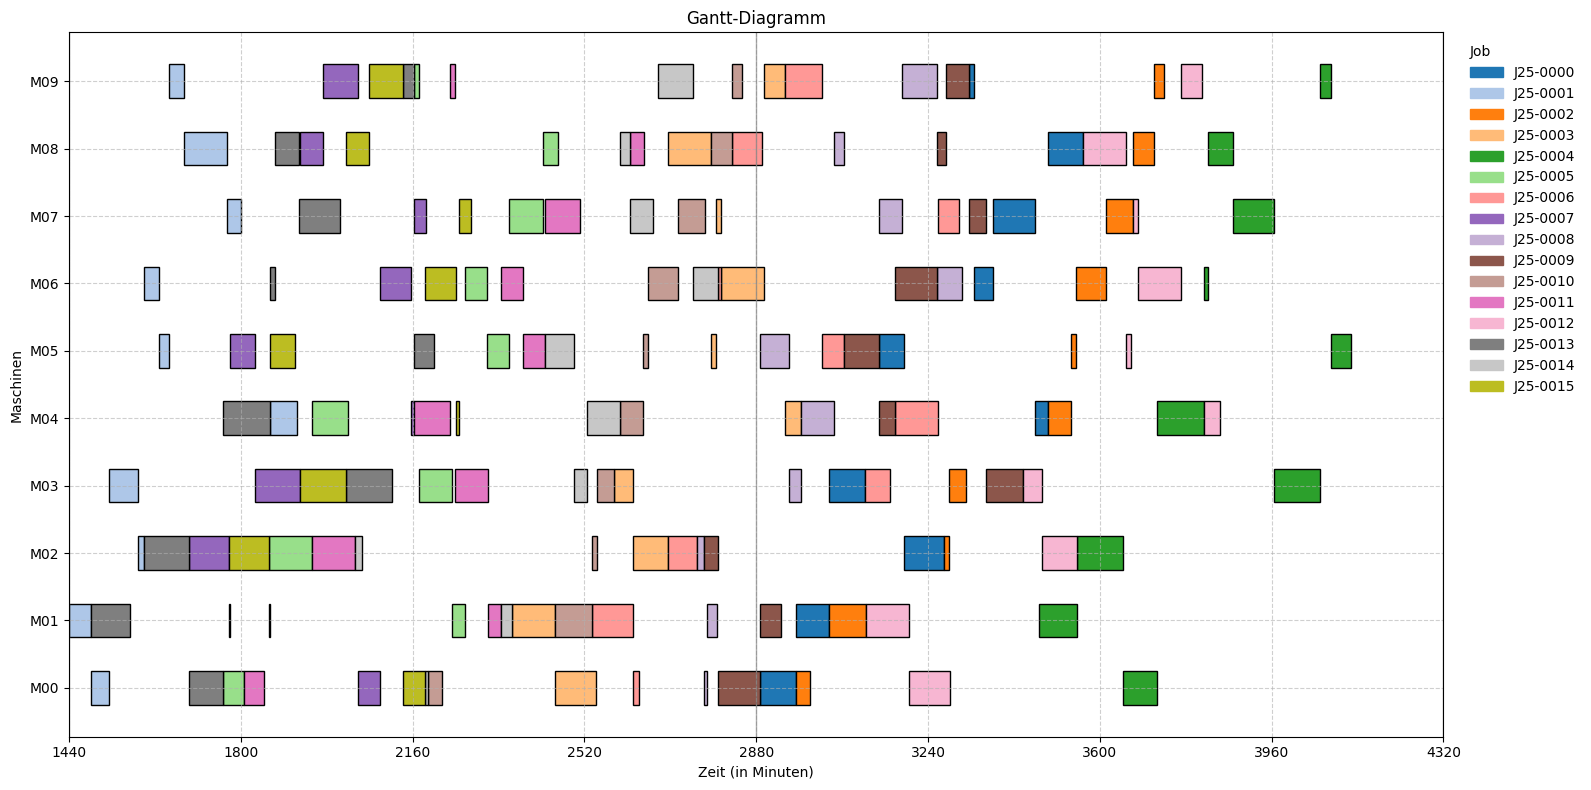

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [9]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

### Simulation

In [10]:
simulation.run(dframe_schedule_plan= df_schedule, start_time = day_start, end_time=day_end)

[Day 1 00:00:00] Job J25-0001 started on M01
[Day 1 00:46:00] Job J25-0001 finished on M01 (after 46 minutes)
[Day 1 00:46:00] Job J25-0013 started on M01
[Day 1 00:46:00] Job J25-0001 started on M00
[Day 1 01:35:00] Job J25-0001 finished on M00 (after 49 minutes)
[Day 1 01:35:00] Job J25-0001 started on M03
[Day 1 02:20:00] Job J25-0013 finished on M01 (after 94 minutes)
[Day 1 02:37:00] Job J25-0013 started on M02
[Day 1 02:49:00] Job J25-0001 finished on M03 (after 74 minutes)
[Day 1 04:10:00] Job J25-0013 finished on M02 (after 93 minutes)
[Day 1 04:10:00] Job J25-0001 started on M02
[Day 1 04:12:00] Job J25-0013 started on M00
[Day 1 04:21:00] Job J25-0001 finished on M02 (after 11 minutes)
[Day 1 04:21:00] Job J25-0007 started on M02
[Day 1 04:21:00] Job J25-0001 started on M06
[Day 1 04:56:00] Job J25-0001 finished on M06 (after 35 minutes)
[Day 1 04:56:00] Job J25-0001 started on M05
[Day 1 05:16:00] Job J25-0001 finished on M05 (after 20 minutes)
[Day 1 05:16:00] Job J25-0001 

In [11]:
df_execution = simulation.get_finished_operations_df()
df_execution

,Routing_ID,Job,Operation,Machine,Arrival,Start,Processing Time,End
0,6,J25-0001,0,M01,129,1440.0,46.0,1486.0
1,6,J25-0001,1,M00,129,1486.0,49.0,1535.0
2,6,J25-0001,2,M03,129,1535.0,74.0,1609.0
3,6,J25-0001,3,M02,129,1690.0,11.0,1701.0
4,6,J25-0001,4,M06,129,1701.0,35.0,1736.0
5,6,J25-0001,5,M05,129,1736.0,20.0,1756.0
...,...,...,...,...,...,...,...,...
89,5,J25-0015,4,M08,1436,2051.0,46.0,2097.0
90,5,J25-0015,5,M09,1436,2097.0,97.0,2194.0
91,5,J25-0015,6,M00,1436,2224.0,48.0,2272.0


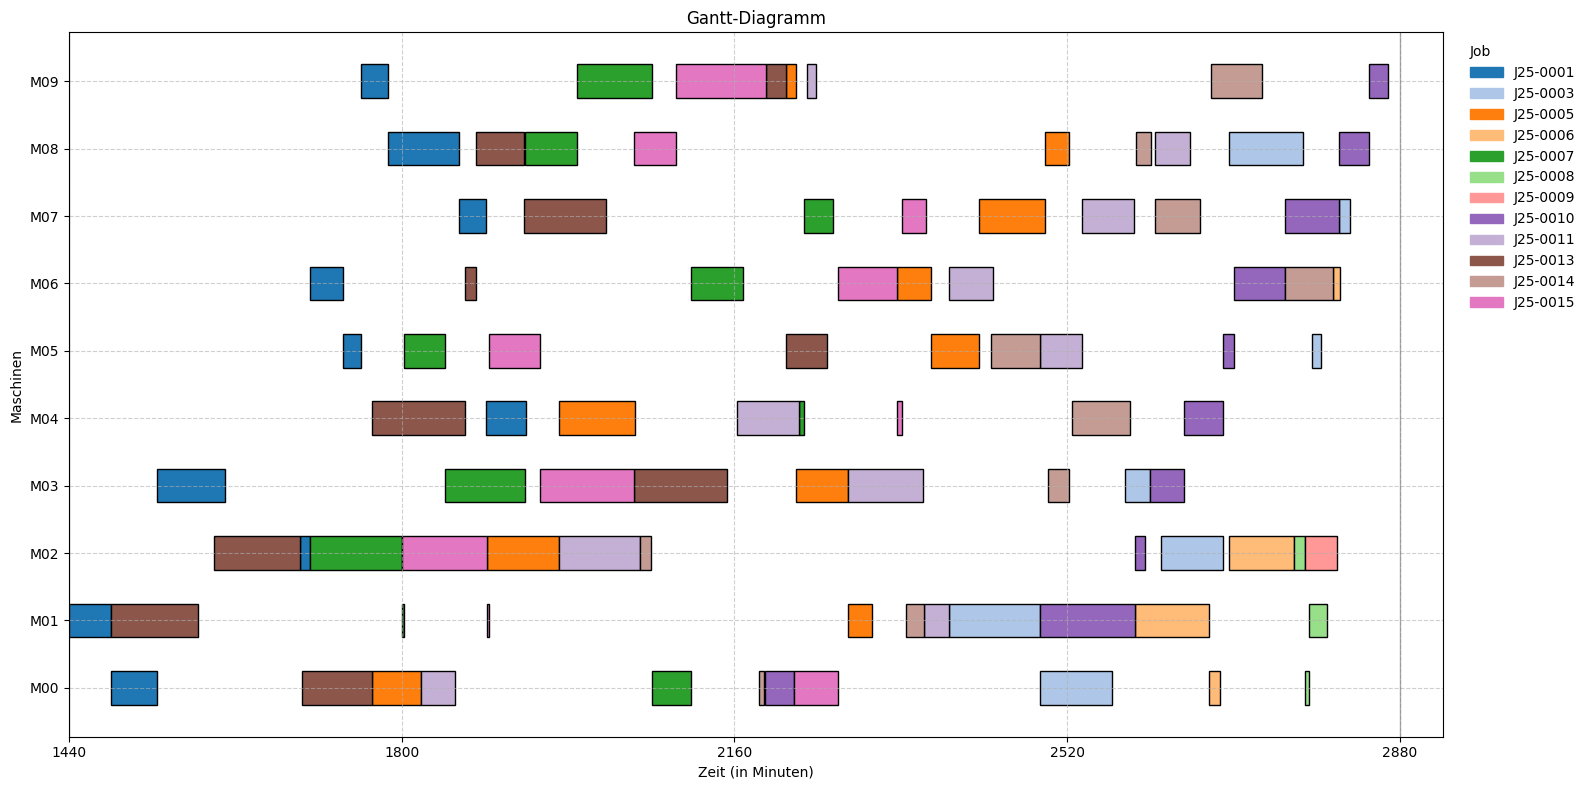

In [12]:
show.plot_gantt(df_execution, perspective="Machine")

In [13]:
df_active = simulation.get_active_operations_df()
df_active

,Job,Operation,Machine,Arrival,Start,Planned Duration,Processing Time,Expected End,End
0,J25-0003,7,M06,243,2826.0,89,81.0,2915.0,2907.0
1,J25-0006,4,M08,790,2846.0,64,62.0,2910.0,2908.0
2,J25-0009,1,M00,1004,2812.0,86,108.0,2898.0,2920.0


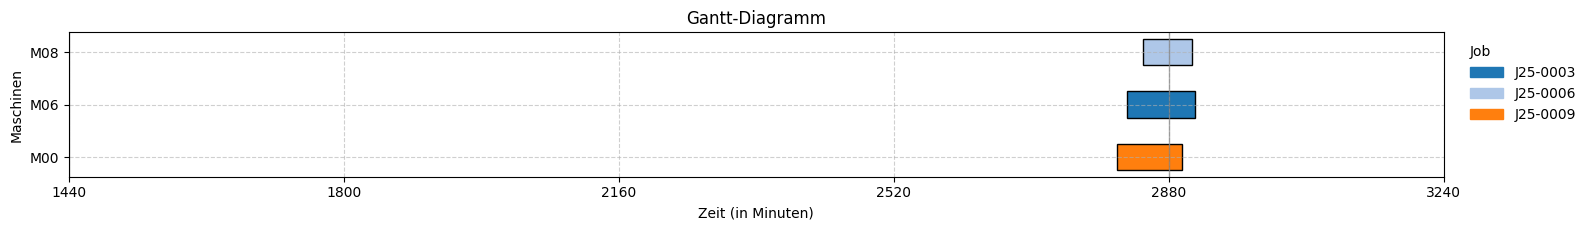

In [14]:
show.plot_gantt(df_active, perspective="Machine", duration_column="Planned Duration")

In [15]:
df_not_started = simulation.get_not_started_operations_df(df_schedule)
df_not_started

,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Deadline,Start,End,Tardiness
0,J25-0000,8,0,M00,76,79,1440,3660,2887.0,2963.0,0.0
1,J25-0000,8,1,M01,69,79,1440,3660,2963.0,3032.0,0.0
2,J25-0000,8,2,M03,76,79,1440,3660,3032.0,3108.0,0.0
3,J25-0000,8,3,M05,51,79,1440,3660,3138.0,3189.0,0.0
4,J25-0000,8,4,M02,85,79,1440,3660,3189.0,3274.0,0.0
5,J25-0000,8,5,M09,11,79,1440,3660,3325.0,3336.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
56,J25-0012,2,4,M08,90,1103,1440,4385,3565.0,3655.0,0.0
57,J25-0012,2,5,M05,10,1103,1440,4385,3655.0,3665.0,0.0
58,J25-0012,2,6,M07,12,1103,1440,4385,3669.0,3681.0,0.0


#### b) größte Tardiness minimieren

$$
\min \; \max_{j \in J} \left( \max(0,\; C_j - d_j) \right)
$$


- $J$: Menge aller Jobs
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$
- $d_j$: Deadline von Job $j$
- $\max(0,\; C_j - d_j)$: Tardiness des Jobs $j$
- Die äußere $\max$-Funktion bestimmt den Job mit der **größten Verspätung**

**Erklärung:**
Diese Zielfunktion minimiert die **schlimmste Deadline-Überschreitung** unter allen Jobs. Frühfertigungen fließen dabei **nicht** ein.

In [16]:
# Scheduling
df_schedule_b = lp_tard_schedule.solve_jssp_max(
    df_jssp_current, df_jobs_times_current, solver="HiGHS",
    earliest_start_column = "Ready Time", msg=False, timeLimit=max_time, gapRel=0.01)
df_schedule_b


Solver-Informationen:
  Maximale Tardiness      : 0.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 1393
  Anzahl Constraints      : 2592
  Laufzeit                : ~2 Sekunden


,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Deadline,Start,End,Tardiness
0,J25-0000,8,0,M00,76,79,1440,3660,2316.0,2392.0,0.0
1,J25-0000,8,1,M01,69,79,1440,3660,2392.0,2461.0,0.0
2,J25-0000,8,2,M03,76,79,1440,3660,2474.0,2550.0,0.0
3,J25-0000,8,3,M05,51,79,1440,3660,2761.0,2812.0,0.0
4,J25-0000,8,4,M02,85,79,1440,3660,2812.0,2897.0,0.0
5,J25-0000,8,5,M09,11,79,1440,3660,2897.0,2908.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
154,J25-0015,5,4,M08,48,1436,1440,2981,2009.0,2057.0,0.0
155,J25-0015,5,5,M09,72,1436,1440,2981,2087.0,2159.0,0.0
156,J25-0015,5,6,M00,47,1436,1440,2981,2159.0,2206.0,0.0


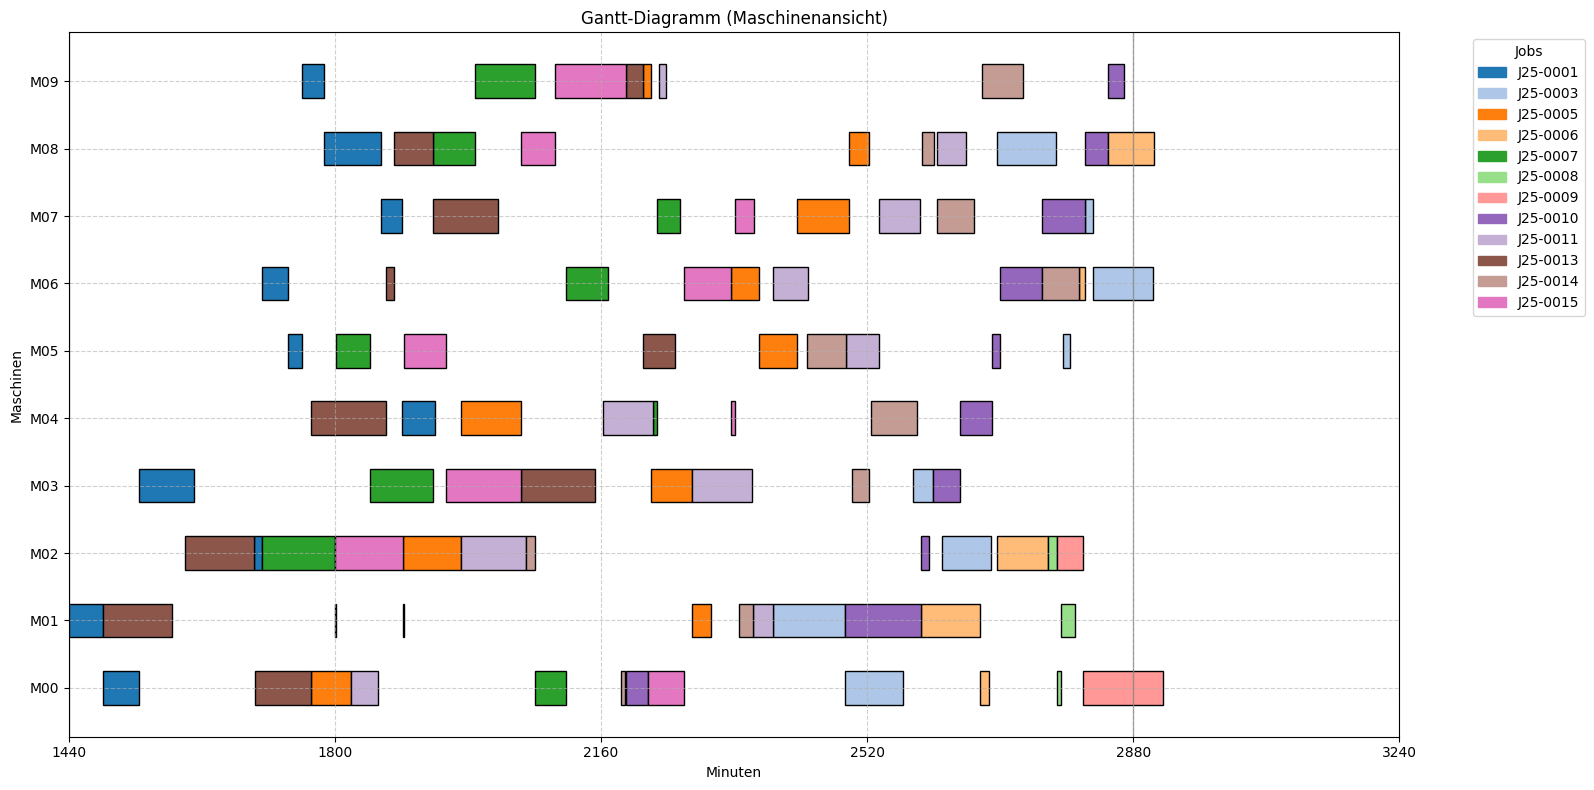

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [17]:
columns = ["Job", "Operation", "Machine", "Arrival", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns]], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)

## Tag 2
- hier findet die Neuplanung statt, also das Scheduling mit bestimmter Berücksichtigung der Simulation

In [18]:
day_numb = 2
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [19]:
# "neue" und unerledigte Jobs
df_jobs_times_current = get_current_jobs(df_jobs_times, df_not_started, ready_time=day_start)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
6,J25-0006,9,790,1440,2905.0,540,3539
8,J25-0008,4,988,1440,2986.0,393,3541
...,...,...,...,...,...,...,...
32,J25-0032,6,2654,2880,4856.0,416,3881
33,J25-0033,2,2660,2880,5305.0,568,6738
34,J25-0034,8,2715,2880,5271.0,597,6387


In [20]:
df_jssp_current = filter_current_jssp(
    df_jssp = df_jssp,
    df_jobs_times_current = df_jobs_times_current,
    exclusion_dataframes_list = [df_active, df_execution]
)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
374,J25-0037,7,4,M04,32
375,J25-0037,7,5,M06,88
376,J25-0037,7,6,M08,19


### a) einfache Neuplanung
- berücksichtigt lediglich die aktiven Arbeitsgänge (Operationen)

In [21]:
df_schedule_simple = lp_tard_reschedule.solve_jssp_sum_with_fixed_ops(
    df_jssp_current, df_jobs_times_current, df_active,
    reschedule_start = day_start, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.02
)
df_schedule_simple

BigM: 9000

Solver-Informationen:
  Summe Tardiness         : 694.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 4269
  Anzahl Constraints      : 8196
  Laufzeit                : ~900 Sekunden


,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Deadline,Start,End,Tardiness
0,J25-0000,8,0,M00,76,79,1440,3660,2920.0,2996.0,0.0
1,J25-0000,8,1,M01,69,79,1440,3660,3012.0,3081.0,0.0
2,J25-0000,8,2,M03,76,79,1440,3660,3081.0,3157.0,0.0
3,J25-0000,8,3,M05,51,79,1440,3660,3157.0,3208.0,0.0
4,J25-0000,8,4,M02,85,79,1440,3660,3208.0,3293.0,0.0
5,J25-0000,8,5,M09,11,79,1440,3660,3293.0,3304.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
276,J25-0037,7,4,M04,32,2801,2880,5173,4769.0,4801.0,0.0
277,J25-0037,7,5,M06,88,2801,2880,5173,4808.0,4896.0,0.0
278,J25-0037,7,6,M08,19,2801,2880,5173,4896.0,4915.0,0.0


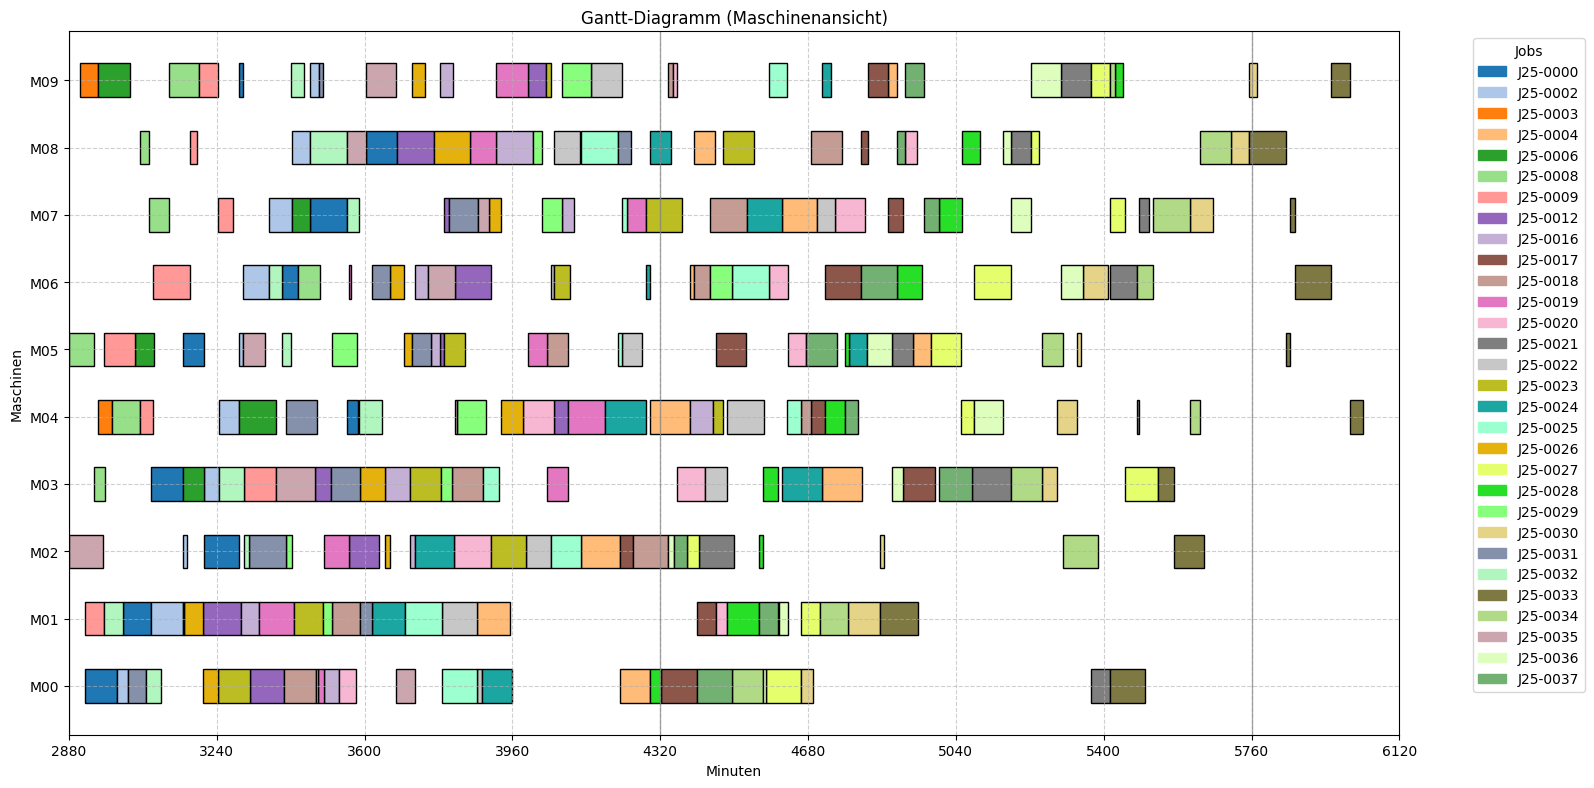

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [22]:
df_temp =  df_schedule_simple

show.plot_gantt_machines(df_temp)
check.is_machine_conflict_free(df_temp)
check.is_operation_sequence_correct(df_temp)
check.is_job_timing_correct(df_temp)
check.is_start_correct(df_temp)

#### Check der Bedingungen des kombinierten Datensatzes aus den Simulationsdaten mit dem neuen Schedule

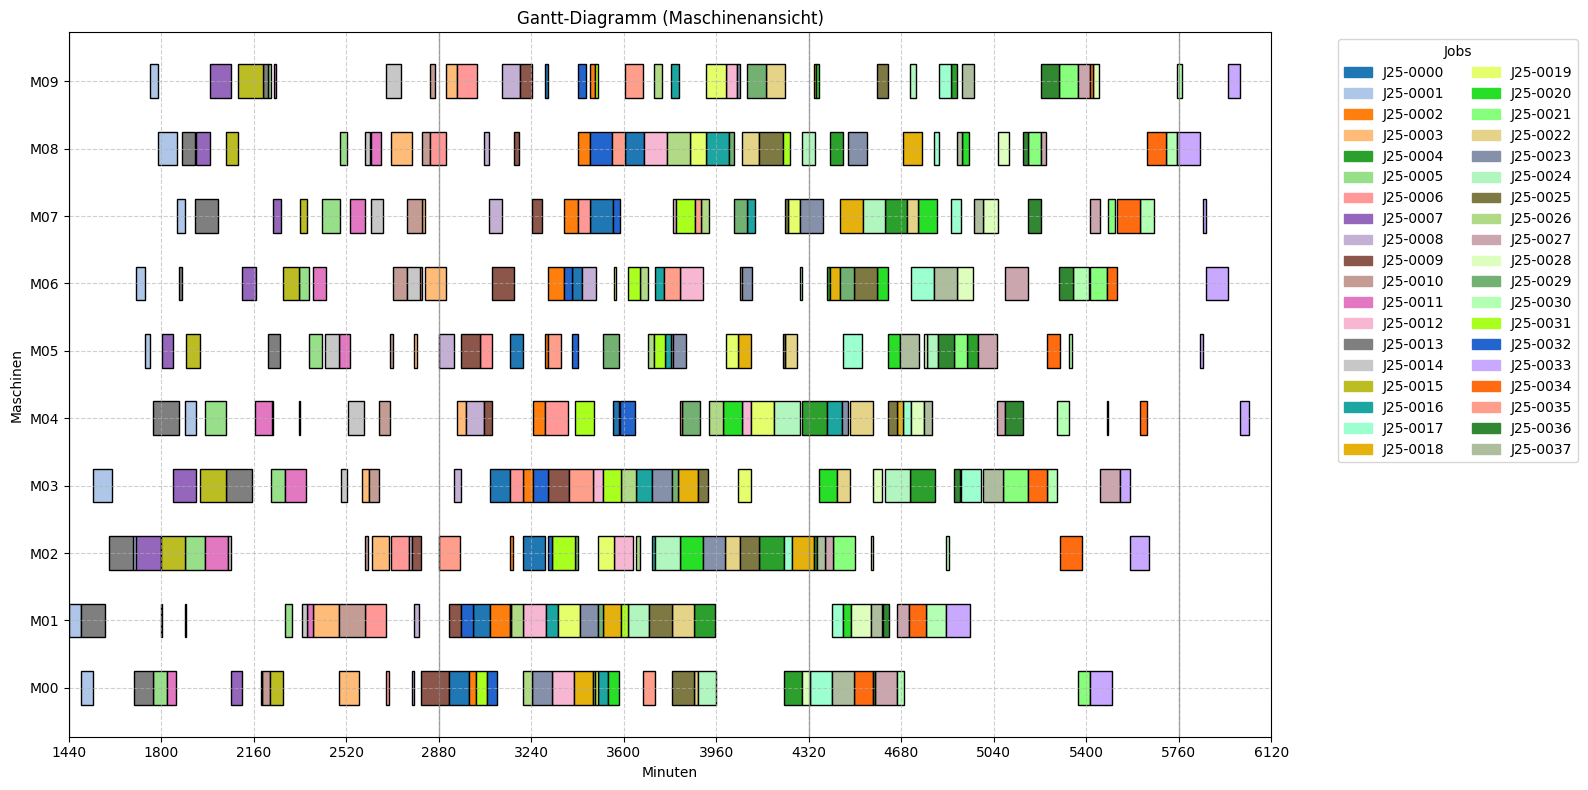

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [23]:
df_reschedule = df_schedule_simple

columns = ["Job", "Operation", "Machine", "Arrival", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)


### b) Neuplanung mit zusätzlich Minimierung der Planabweichung für die zuvor geplante Arbeitsgänge

In [25]:
df_schedule_devpen = lp_tard_reschedule.solve_jssp_sum_with_devpen(
    df_jssp_current, df_jobs_times_current, df_active,
    df_original_plan = df_schedule,                     # prev. Plan
    r = 0.60,                                           # 60% Flowtime, 40% Abweichung
    reschedule_start = day_start, solver= "HiGHS",
    msg=False, timeLimit=max_time, gapRel= 0.02
)
df_schedule_devpen

BigM: 12000

Solver-Informationen:
  Zielfunktionswert       : 15764.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 4331
  Anzahl Constraints      : 8320
  Laufzeit                : ~900 Sekunden


,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Deadline,Start,End,Tardiness
0,J25-0000,8,0,M00,76,79,1440,3660,2920.0,2996.0,0.0
1,J25-0000,8,1,M01,69,79,1440,3660,2996.0,3065.0,0.0
2,J25-0000,8,2,M03,76,79,1440,3660,3065.0,3141.0,0.0
3,J25-0000,8,3,M05,51,79,1440,3660,3149.0,3200.0,0.0
4,J25-0000,8,4,M02,85,79,1440,3660,3200.0,3285.0,0.0
5,J25-0000,8,5,M09,11,79,1440,3660,3336.0,3347.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
276,J25-0037,7,4,M04,32,2801,2880,5173,4878.0,4910.0,0.0
277,J25-0037,7,5,M06,88,2801,2880,5173,4910.0,4998.0,0.0
278,J25-0037,7,6,M08,19,2801,2880,5173,4998.0,5017.0,0.0


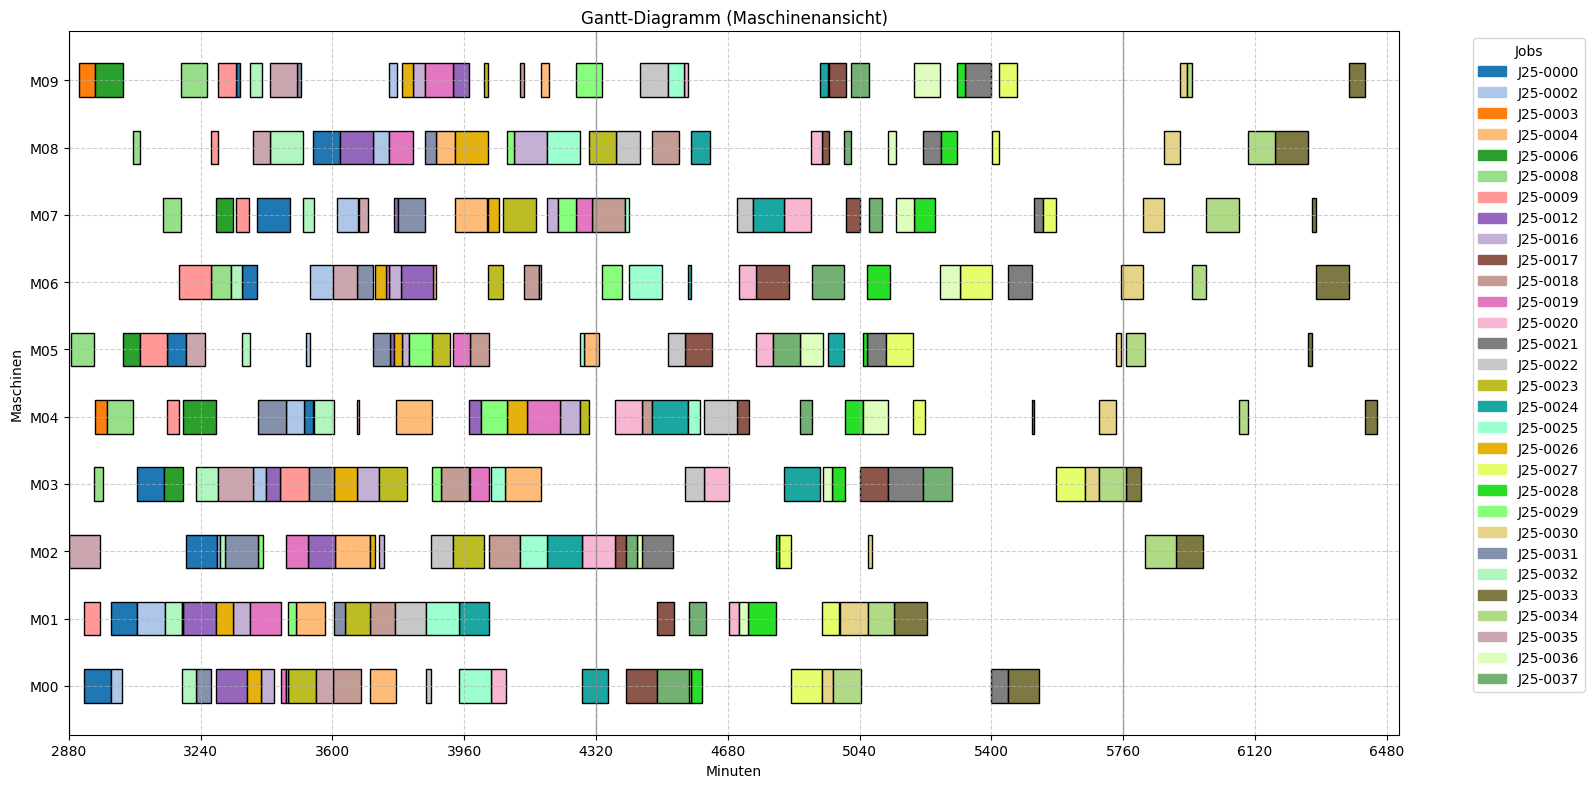

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [28]:
df_temp =  df_schedule_devpen

show.plot_gantt_machines(df_temp)
check.is_machine_conflict_free(df_temp)
check.is_operation_sequence_correct(df_temp)
check.is_job_timing_correct(df_temp)
check.is_start_correct(df_temp)

#### Check der Bedingungen des kombinierten Datensatzes aus den Simulationsdaten mit dem neuen Schedule

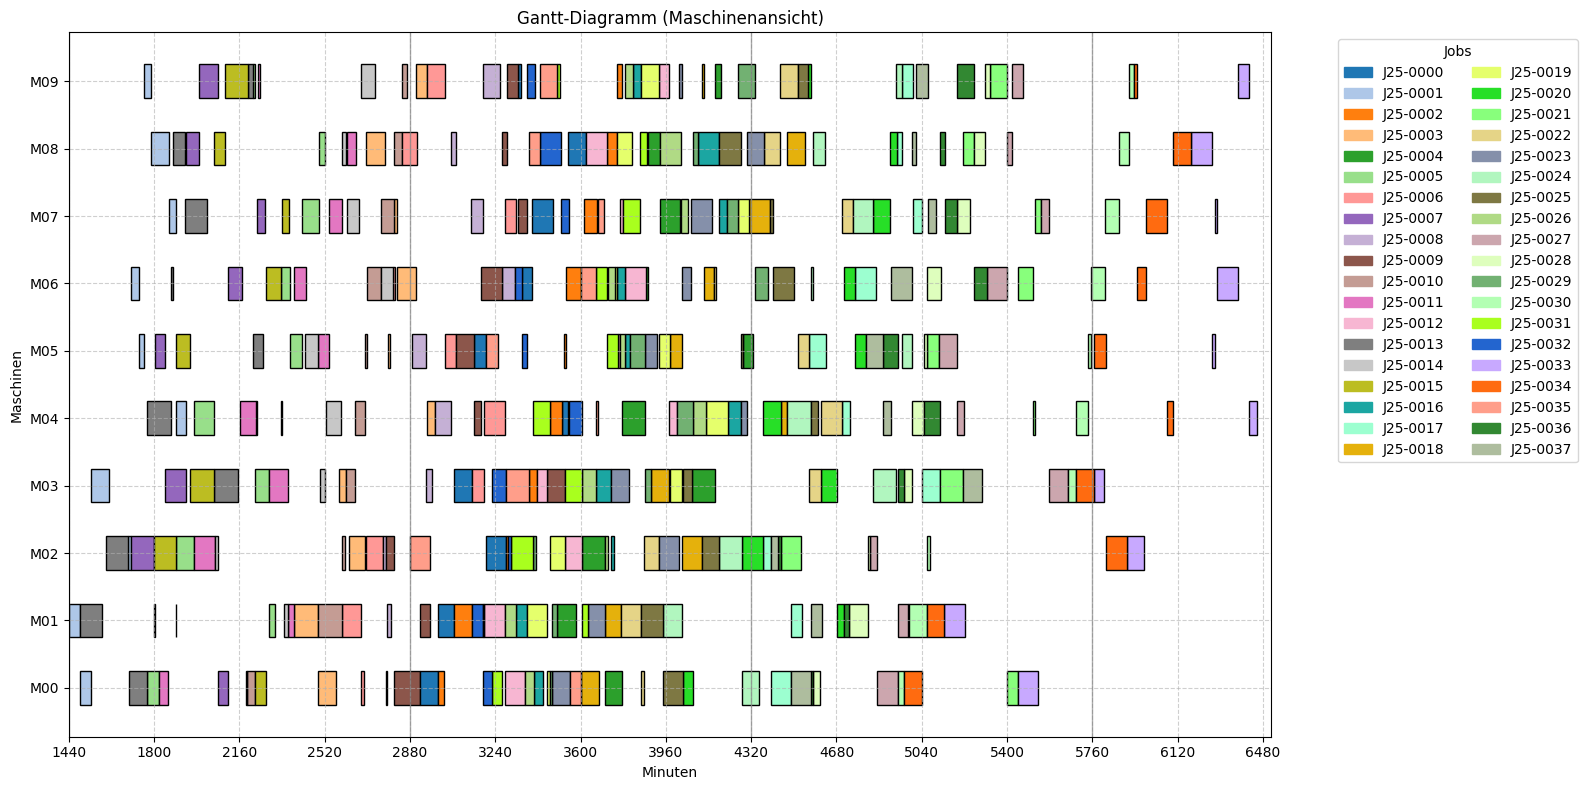

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [29]:
df_reschedule = df_schedule_devpen

columns = ["Job", "Operation", "Machine", "Arrival", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)


### Simulation

In [30]:
simulation.run(dframe_schedule_plan = df_schedule_devpen, start_time = day_start, end_time = day_end)

[Day 2 00:00:00] Job J25-0009, Operation 1 resumed with 40.00 min
[Day 2 00:00:00] Job J25-0003, Operation 7 resumed with 27.00 min
[Day 2 00:00:00] Job J25-0006, Operation 4 resumed with 28.00 min
[Day 2 00:00:00] Job J25-0035 started on M02
[Day 2 00:07:00] Job J25-0008 started on M05
[Day 2 00:27:00] Job J25-0003 finished on M06 (after 27 minutes)
[Day 2 00:27:00] Job J25-0003 started on M09
[Day 2 00:28:00] Job J25-0006 finished on M08 (after 28 minutes)
[Day 2 00:40:00] Job J25-0009 finished on M00 (after 40 minutes)
[Day 2 00:40:00] Job J25-0000 started on M00
[Day 2 00:40:00] Job J25-0009 started on M01
[Day 2 01:02:00] Job J25-0008 finished on M05 (after 55 minutes)
[Day 2 01:05:00] Job J25-0003 finished on M09 (after 38 minutes)
[Day 2 01:08:00] Job J25-0008 started on M03
[Day 2 01:12:00] Job J25-0006 started on M09
[Day 2 01:12:00] Job J25-0003 started on M04
[Day 2 01:18:00] Job J25-0009 finished on M01 (after 38 minutes)
[Day 2 01:28:00] Job J25-0035 finished on M02 (after

In [31]:
df_execution2 = simulation.get_finished_operations_df()
df_execution2

,Job,Operation,Machine,Arrival,Start,Processing Time,End,Routing_ID
0,J25-0000,0,M00,79,2920.0,88.0,3008.0,8.0
1,J25-0000,1,M01,79,3008.0,73.0,3081.0,8.0
2,J25-0000,2,M03,79,3081.0,77.0,3158.0,8.0
3,J25-0000,3,M05,79,3170.0,53.0,3223.0,8.0
4,J25-0000,4,M02,79,3223.0,80.0,3303.0,8.0
5,J25-0000,5,M09,79,3368.0,10.0,3378.0,8.0
...,...,...,...,...,...,...,...,...
150,J25-0035,4,M08,2726,3399.0,47.0,3446.0,5.0
151,J25-0035,5,M09,2726,3446.0,76.0,3522.0,5.0
152,J25-0035,6,M00,2726,3578.0,45.0,3623.0,5.0


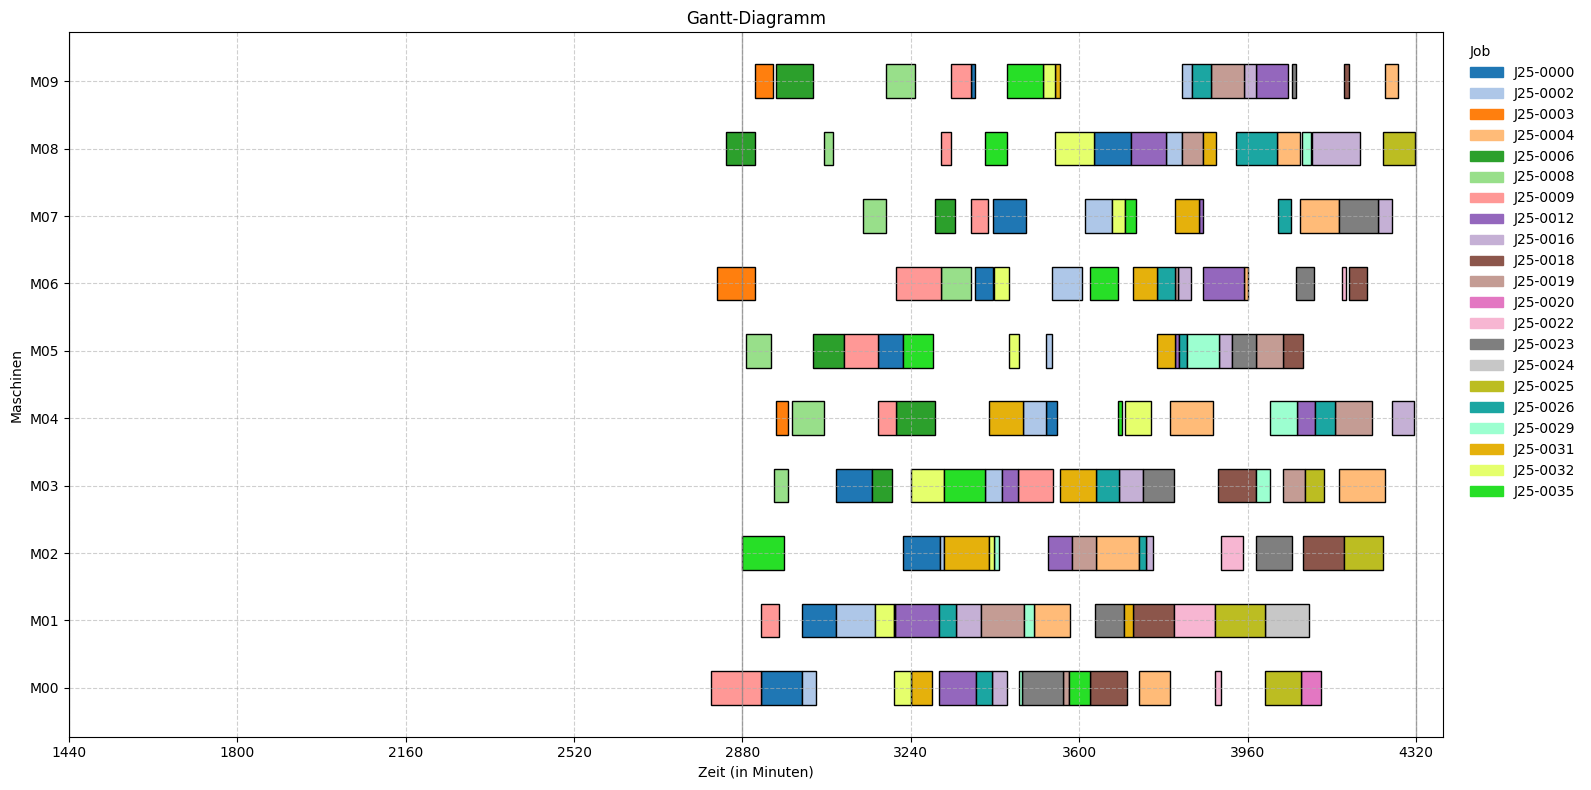

In [32]:
show.plot_gantt(df_execution2, perspective="Machine")

In [33]:
df_active2 = simulation.get_active_operations_df()
df_active2

,Job,Operation,Machine,Arrival,Start,Planned Duration,Processing Time,Expected End,End
0,J25-0004,9,M05,287,4286.0,43,48.0,4329.0,4334.0
1,J25-0023,8,M04,2055,4315.0,26,25.0,4341.0,4340.0
2,J25-0024,1,M02,2108,4250.0,95,71.0,4345.0,4321.0
3,J25-0029,7,M07,2301,4269.0,49,53.0,4318.0,4322.0


In [34]:
df_not_started2 = simulation.get_not_started_operations_df(df_schedule)
df_not_started2

,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Deadline,Start,End,Tardiness
0,J25-0001,6,0,M01,46,129,1440,2338,1440.0,1486.0,0.0
1,J25-0001,6,1,M00,37,129,1440,2338,1486.0,1523.0,0.0
2,J25-0001,6,2,M03,61,129,1440,2338,1523.0,1584.0,0.0
3,J25-0001,6,3,M02,13,129,1440,2338,1584.0,1597.0,0.0
4,J25-0001,6,4,M06,32,129,1440,2338,1597.0,1629.0,0.0
5,J25-0001,6,5,M05,21,129,1440,2338,1629.0,1650.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
89,J25-0015,5,4,M08,48,1436,1440,2981,2020.0,2068.0,0.0
90,J25-0015,5,5,M09,72,1436,1440,2981,2068.0,2140.0,0.0
91,J25-0015,5,6,M00,47,1436,1440,2981,2140.0,2187.0,0.0


#### Check der Bedingungen des kombinierten Datensatzes aus den beiden Simulationsdaten

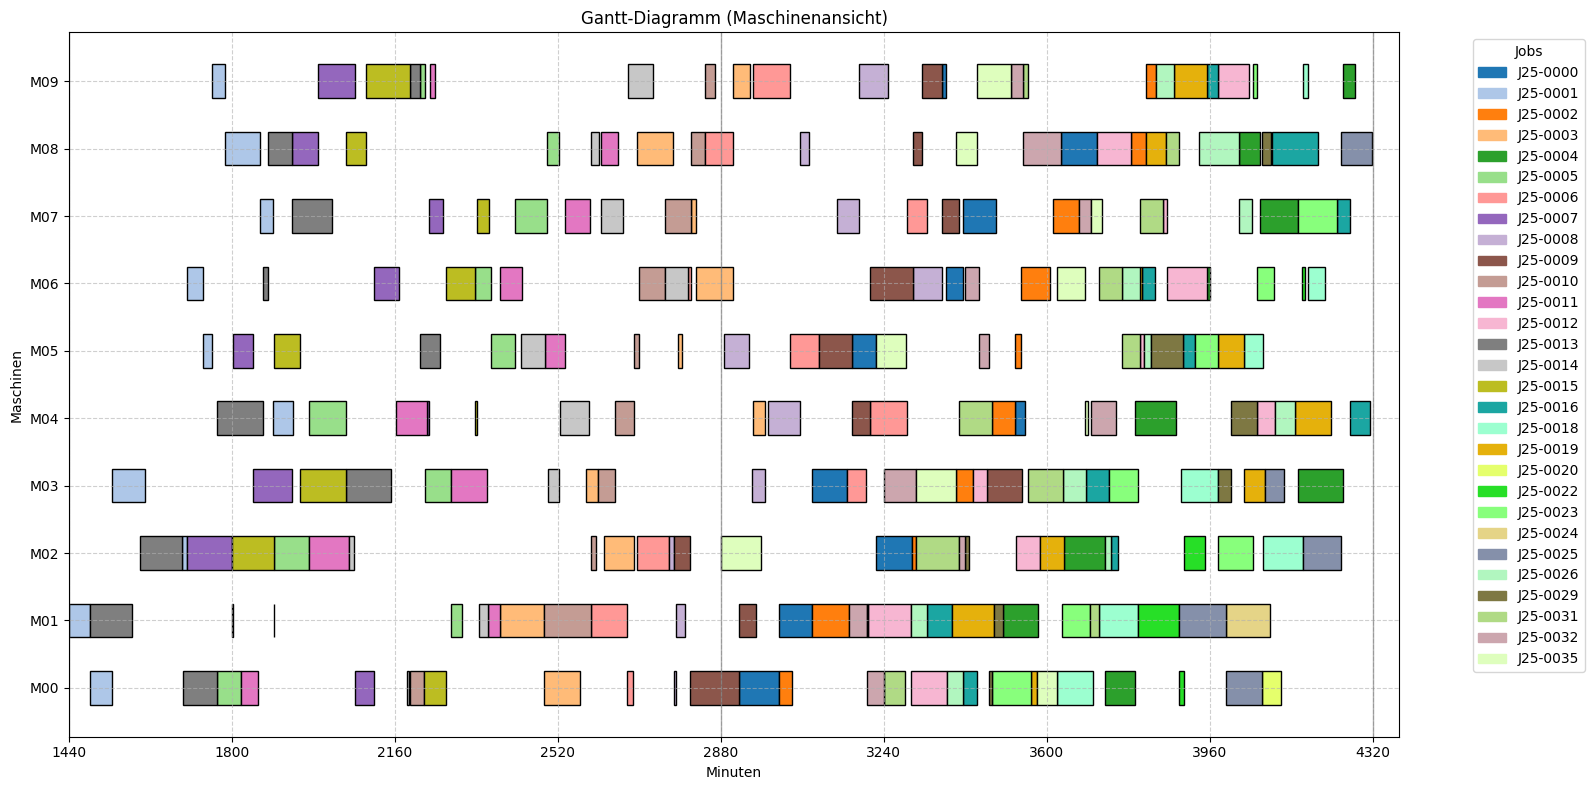

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [35]:
df_combined = pd.concat([df_execution, df_execution2], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)